In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt


In [2]:
env = gym.make("Taxi-v3", render_mode="ansi")
env.reset()

(102, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [3]:
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [4]:
action_size = env.action_space.n
state_size = env.observation_space.n

(6, 500)

In [5]:
qtable = np.zeros((state_size,action_size))
qtable, qtable.shape

(array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 (500, 6))

In [6]:
def greedy_policy(qtable, state, explo_rate):
    if np.random.uniform(0,1) < explo_rate:
        return np.random.randint(0,6)
    else:
        return np.argmax(qtable[state,:])

In [7]:
# Evaluates/tests the policy over a single episode
def policy_eval(qtable, n_steps, discount, explo_rate):
    state = env.reset()[0]
    total_steps = 0
    total_reward = 0
    for step in range(n_steps):
        action = greedy_policy(qtable, state, explo_rate)
        new_state, reward, done, truncated, info = env.step(action)
        state = new_state
        total_reward += reward*discount**step
        
        if done: 
            total_steps = step + 1  
            break
        else:
            total_steps = step + 1

    return total_reward, total_steps    
                

In [8]:
# Evaluates/tests the policy fully over many iterations
def full_policy_eval(qtable, n_episodes, n_steps, discount, explo_rate):
    episode_returns = []
    episode_steps = []
    for episode in range(n_episodes):
        total_reward, steps = policy_eval(qtable, n_steps, discount, explo_rate)
        episode_steps.append(steps)
        episode_returns.append(total_reward)
        
    return np.mean(episode_returns), np.min(episode_returns), np.max(episode_returns), np.std(episode_returns), np.mean(episode_steps)

In [9]:
def training(Q, lr, discount, min_explorate, explo_rate, decay, n_episodes, n_steps):
    hist = []
    for episode in range(n_episodes):
        state = env.reset()[0]
        
        for step in range(n_steps):
            # Let the agent act
            action = greedy_policy(qtable, state, explo_rate)
            new_state, reward, done, truncated, info = env.step(action)        
            
            # Updating Qtable (policy) with bellmans equation
            Q[state,action] = Q[state, action] + lr*(reward+discount*np.max(Q[state])-Q[state,action])
            state = new_state
            if done: break
        
        exploration_rate = max(min_explorate, explo_rate * decay)
        if episode % 10 == 0 or episode == 1:
            mean_return, smallest_return, best_return, std_return, mean_steps = full_policy_eval(Q, 10, n_steps, discount, min_explorate)
            hist.append([episode, mean_return,smallest_return,best_return,std_return, mean_steps])
    return Q, hist

In [10]:
# Hyperparameters
learning_rate = 0.02
discount = 0.85
exploration_rate = 0.995
min_explorate = 0.1
decay = 0.8
n_episodes = 1000
n_steps = 404

In [11]:
qtable, hist_eval = training(qtable, learning_rate, discount, min_explorate, exploration_rate, decay, n_episodes, n_steps)
print(qtable)

e:\Anaconda3\envs\venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.24719396  -2.18917855  -2.26336711  -2.24900186  -2.27220681
  -11.11360783]
 [ -2.26008153  -2.36389165  -2.30486348  -2.34143632  -2.40768447
  -10.78889061]
 ...
 [ -1.16925533  -1.40261307  -1.29289527  -1.32975349  -8.41333534
   -7.97395127]
 [ -2.13466072  -2.31442246  -2.17226601  -2.11050759 -10.70419619
  -10.6929726 ]
 [ -0.75722095  -0.78899588  -0.69927016  -0.68792072  -5.91550059
   -6.54245812]]


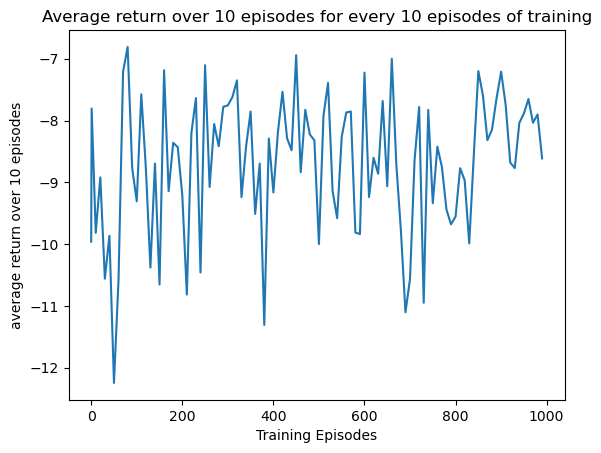

In [12]:
hist_eval = np.array(hist_eval)
plt.plot(hist_eval[:,0], hist_eval[:, 1])
plt.title("Average return over 10 episodes for every 10 episodes of training")
plt.xlabel("Training Episodes")
plt.ylabel("average return over 10 episodes")
plt.show()

In [13]:
# Test hyperparams
test_episodes = 1000
test_steps = n_steps
test_discount = discount

In [14]:
mean_return, smallest_return, best_return, std_return, mean_steps = full_policy_eval(qtable, test_episodes, test_steps, test_discount, min_explorate)

print(f"Average return over {test_episodes} episodes is: {mean_return}")
print(f"Smallest return of the {test_episodes} episodes is: {smallest_return}")
print(f"Greatest return of the {test_episodes} episodes is: {best_return}")
print(f"std return of the {test_episodes} episodes is: {std_return}")
print(f"Average amounts of steps over {test_episodes} episodes is: {mean_steps}")

Average return over 1000 episodes is: -8.671650256920387
Smallest return of the 1000 episodes is: -23.720506745354513
Greatest return of the 1000 episodes is: -6.666666666666662
std return of the 1000 episodes is: 3.0422904544755203
Average amounts of steps over 1000 episodes is: 402.848
